In [495]:
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from scipy.special import comb, logsumexp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import random

In [511]:
PATH_BUILDING_ENERGY_FEATURIZED = "../data/building_energy_featurized.csv"

PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE = "../data/building_energy_featurized_zscore.csv"
PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE = "../data/building_energy_featurized_undo_zscore.csv"

PATH_BUILDING_ENERGY_LSTM_ZSCORE = "../data/building_energy_lstm_zscore.csv"
PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE = "../data/building_energy_lstm_undo_zscore.csv"

random.seed(5)

In [514]:
building_energy_featurized = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED)
building_energy_featurized_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_ZSCORE)
building_energy_featurized_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_FEATURIZED_UNDO_ZSCORE)

print(building_energy_featurized.head())
print(building_energy_featurized_zscore.head())
print(building_energy_featurized_undo_zscore)

BUILDING_ENERGY_DATASET = building_energy_featurized_zscore

   year  month  day  hour  kwh_actual  target_00600340190000  \
0  2016      1    1     1          38                      1   
1  2016      1    1     2          36                      1   
2  2016      1    1     3          37                      1   
3  2016      1    1     4          36                      1   
4  2016      1    1     5          37                      1   

   target_00600470060000  target_00600470080000  target_00600470120000  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   target_00600910010000  ...  kwh_sim_00601060040000  kwh_sim_00601060050000  \
0                      0  ...                      83                     100   
1       

In [498]:
# Rows with kwh values of 0 are removed to allow for log-scaling (per-building standard scaling to z-scores eliminates need for log scaling)
# log_building_energy_featurized = BUILDING_ENERGY_DATASET.apply(lambda x: np.log(x.replace(0, np.nan)) if x.name.startswith("kwh_sim_") else x).dropna()

building_energy_scaled = BUILDING_ENERGY_DATASET

# Scale temporal variables via simple minmax (because they are roughly uniformly distributed)
min_max_scaler = preprocessing.MinMaxScaler()
building_energy_scaled[['year', 'month', 'day', 'hour']] = min_max_scaler.fit_transform(building_energy_scaled[['year', 'month', 'day', 'hour']])

In [499]:
X = np.array(building_energy_scaled.drop(columns=['kwh_actual']))
y = np.array(building_energy_scaled.filter(items=['kwh_actual']))

X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

train_undo_zscore = X_train[:, 4:6]
val_undo_zscore = X_val[:, 4:6]
test_undo_zscore = X_test[:, 4:6]

X_train = np.delete(X_train, [4, 5], 1)
X_val = np.delete(X_val, [4, 5], 1)
X_test = np.delete(X_test, [4, 5], 1)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(533955, 74) (114419, 74) (114419, 74) (533955, 1) (114419, 1) (114419, 1)


In [500]:
# Model that predicts the mean for each building (i.e. 0 z-score)

y_predictions = np.zeros(y_val.ravel().shape)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 49.17184044908783
CV(RMSE): 60.74324638660709
MBE: -0.18958635115242584


In [501]:
lr_model = LinearRegression()
lr_model = lr_model.fit(X_train, y_train)

In [502]:
# Linear Model

y_predictions = lr_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 35.2386110730272
CV(RMSE): 41.94162686077267
MBE: -0.21351934569859893


In [503]:
gb_model = GradientBoostingRegressor()
gb_model = gb_model.fit(X_train, y_train.ravel())

In [504]:
# Gradient Boost Model

y_predictions = gb_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 29.6215692501416
CV(RMSE): 36.903966564640584
MBE: -0.008873762705407087


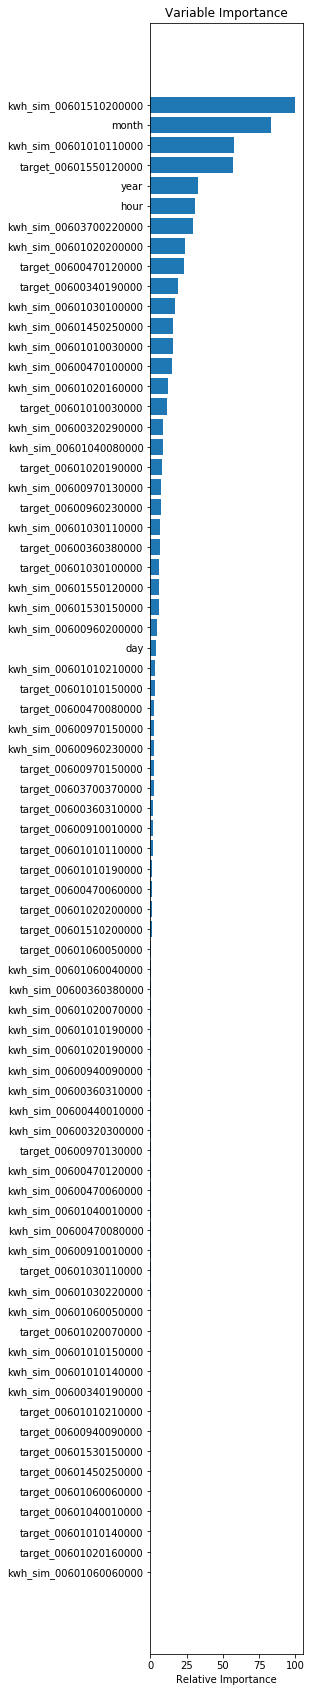

In [505]:
# Plot feature importance
feature_importance = gb_model.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
f = plt.figure(figsize=(6, 30))
f.add_subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, log_building_energy_featurized.drop(columns=['kwh_actual']).columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [506]:
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=[X_train.shape[1]]))
nn_model.add(Dense(128, activation='relu'))
nn_model.add(Dense(1))

nn_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping_monitor = EarlyStopping(patience=3)

nn_model.fit(X_train, y_train, validation_data=[X_val, y_val], epochs=30, callbacks=[early_stopping_monitor])

Train on 533955 samples, validate on 114419 samples
Epoch 1/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.3956 - val_loss: 0.3024
Epoch 2/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2861 - val_loss: 0.2641
Epoch 3/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2632 - val_loss: 0.2453
Epoch 4/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2515 - val_loss: 0.2495
Epoch 5/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2447 - val_loss: 0.2372
Epoch 6/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2397 - val_loss: 0.2263
Epoch 7/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2360 - val_loss: 0.2427
Epoch 8/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.2327 - val_loss: 0.2403
Epoch 9/30
533955/533955 [==============================] - 18s 34us/step - loss: 0.

In [507]:
# Fully Connected Two-Layer NN Model

y_predictions = nn_model.predict(X_val)
true_y_predictions = np.multiply(y_predictions.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
true_y_val = np.multiply(y_val.ravel(), val_undo_zscore[:, 1]) + val_undo_zscore[:, 0]
y_out = np.column_stack((true_y_predictions, true_y_val.astype(int)))
y_out = y_out[y_out[:, 1] != 0]

print("MAPE: " + str(100 * np.mean(np.abs(y_out[:, 0] / y_out[:, 1] - 1))))
print("CV(RMSE): " + str(100 * np.sqrt(np.mean(np.power(true_y_predictions - true_y_val, 2))) / np.mean(true_y_val)))
print("MBE: " + str(np.mean(true_y_predictions - true_y_val)))

MAPE: 18.395829486869793
CV(RMSE): 27.632875801001365
MBE: -0.0030433065737024544


In [508]:
true_y_predictions


array([ 53.49626441,  12.10964096,   6.41226707, ...,  14.20298342,
       188.29464932,  13.48025092])

In [509]:
true_y_val

array([ 53.,  12.,   3., ...,  12., 179.,  15.])

In [513]:
building_energy_lstm_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_ZSCORE)
building_energy_lstm_undo_zscore = pd.read_csv(PATH_BUILDING_ENERGY_LSTM_UNDO_ZSCORE)

print(building_energy_lstm_zscore.head())
print(building_energy_lstm_undo_zscore)

   year  month  day  hour  kwh_actual_00600340190000  \
0  2016      1    1     1                   0.475526   
1  2016      1    1     2                   0.301410   
2  2016      1    1     3                   0.388468   
3  2016      1    1     4                   0.301410   
4  2016      1    1     5                   0.388468   

   kwh_actual_00600470060000  kwh_actual_00600470080000  \
0                  -0.735803                   0.846556   
1                  -0.932332                   1.519910   
2                  -1.325390                   1.519910   
3                  -1.325390                   1.183233   
4                  -0.932332                   1.519910   

   kwh_actual_00600470120000  kwh_actual_00600910010000  \
0                  -0.093399                  -0.952059   
1                  -0.450106                  -0.952059   
2                  -0.701899                  -0.925866   
3                  -0.596985                  -0.952059   
4            

(100, 3000, 4) (100, 3000, 3)
Train on 1500 samples, validate on 1500 samples
Epoch 1/100
1500/1500 [==============================] - 1s 931us/step - loss: 0.3875 - val_loss: 0.3282
Epoch 2/100
1500/1500 [==============================] - 1s 656us/step - loss: 0.2868 - val_loss: 0.2380
Epoch 3/100
1500/1500 [==============================] - 1s 659us/step - loss: 0.2013 - val_loss: 0.1587
Epoch 4/100
1500/1500 [==============================] - 1s 649us/step - loss: 0.1331 - val_loss: 0.1078
Epoch 5/100
1500/1500 [==============================] - 1s 650us/step - loss: 0.0972 - val_loss: 0.0856
Epoch 6/100
1500/1500 [==============================] - 1s 662us/step - loss: 0.0806 - val_loss: 0.0729
Epoch 7/100
1500/1500 [==============================] - 1s 665us/step - loss: 0.0684 - val_loss: 0.0611
Epoch 8/100
1500/1500 [==============================] - 1s 659us/step - loss: 0.0557 - val_loss: 0.0482
Epoch 9/100
1500/1500 [==============================] - 1s 661us/step - loss: 0.0

1500/1500 [==============================] - 1s 653us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 78/100
1500/1500 [==============================] - 1s 637us/step - loss: 9.9004e-04 - val_loss: 0.0012
Epoch 79/100
1500/1500 [==============================] - 1s 638us/step - loss: 9.7580e-04 - val_loss: 0.0012
Epoch 80/100
1500/1500 [==============================] - 1s 643us/step - loss: 9.5885e-04 - val_loss: 0.0011
Epoch 81/100
1500/1500 [==============================] - 1s 643us/step - loss: 9.4662e-04 - val_loss: 0.0011
Epoch 82/100
1500/1500 [==============================] - 1s 646us/step - loss: 9.3309e-04 - val_loss: 0.0011
Epoch 83/100
1500/1500 [==============================] - 1s 637us/step - loss: 9.2256e-04 - val_loss: 0.0011
Epoch 84/100
1500/1500 [==============================] - 1s 654us/step - loss: 9.1123e-04 - val_loss: 0.0011
Epoch 85/100
1500/1500 [==============================] - 1s 644us/step - loss: 9.0200e-04 - val_loss: 0.0011
Epoch 86/100
1500/1500 [===

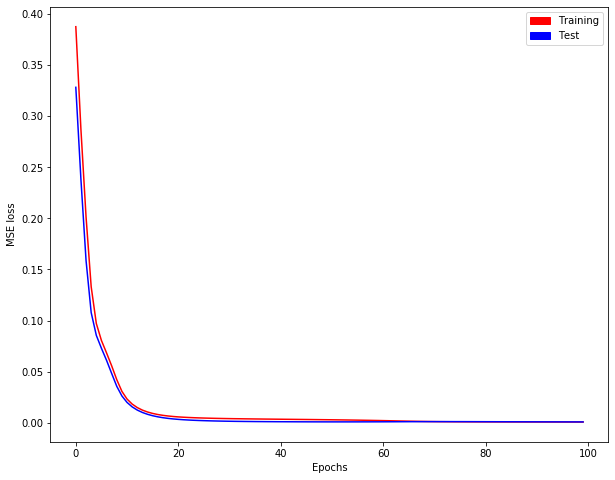

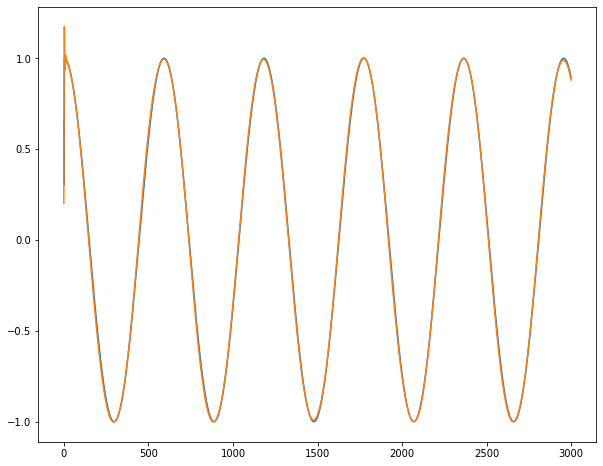

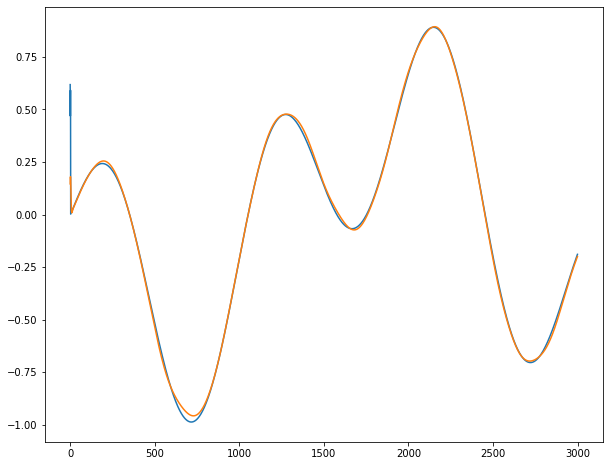

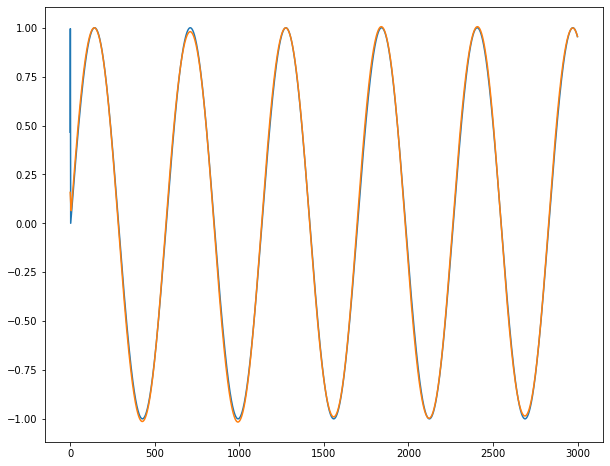

In [515]:
################
import numpy as np
def random_sample(len_timeseries=3000):
    Nchoice = 600
    x1 = np.cos(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x2 = np.cos(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x3 = np.sin(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    x4 = np.sin(np.arange(0,len_timeseries)/float(1.0 + np.random.choice(Nchoice)))
    y1 = np.random.random(len_timeseries)
    y2 = np.random.random(len_timeseries)
    y3 = np.random.random(len_timeseries)
    for t in range(3,len_timeseries):
        ## the output time series depend on input as follows: 
        y1[t] = x1[t-2] 
        y2[t] = x2[t-1]*x3[t-2]
        y3[t] = x4[t-3]
    y = np.array([y1,y2,y3]).T
    X = np.array([x1,x2,x3,x4]).T
    return y, X
def generate_data(Nsequence = 1000):
    X_train = []
    y_train = []
    for isequence in range(Nsequence):
        y, X = random_sample()
        X_train.append(X)
        y_train.append(y)
    return np.array(X_train),np.array(y_train)

Nsequence = 100
prop = 0.5
Ntrain = int(Nsequence*prop)
X, y = generate_data(Nsequence)
X_train = X[:Ntrain,:,:]
X_test  = X[Ntrain:,:,:]
y_train = y[:Ntrain,:,:]
y_test  = y[Ntrain:,:,:] 

#X.shape = (N sequence, length of time series, N input features)
#y.shape = (N sequence, length of time series, N targets)
print(X.shape, y.shape)
# (100, 3000, 4) (100, 3000, 3)

####################
# Cutting function #
####################
def stateful_cut(arr, batch_size, T_after_cut):
    if len(arr.shape) != 3:
        # N: Independent sample size,
        # T: Time length,
        # m: Dimension
        print("ERROR: please format arr as a (N, T, m) array.")

    N = arr.shape[0]
    T = arr.shape[1]

    # We need T_after_cut * nb_cuts = T
    nb_cuts = int(T / T_after_cut)
    if nb_cuts * T_after_cut != T:
        print("ERROR: T_after_cut must divide T")

    # We need batch_size * nb_reset = N
    # If nb_reset = 1, we only reset after the whole epoch, so no need to reset
    nb_reset = int(N / batch_size)
    if nb_reset * batch_size != N:
        print("ERROR: batch_size must divide N")

    # Cutting (technical)
    cut1 = np.split(arr, nb_reset, axis=0)
    cut2 = [np.split(x, nb_cuts, axis=1) for x in cut1]
    cut3 = [np.concatenate(x) for x in cut2]
    cut4 = np.concatenate(cut3)
    return(cut4)

#############
# Main code #
#############
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

##
# Data
##
N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 100 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series

inputs, outputs, inputs_test, outputs_test = \
  [stateful_cut(arr, batch_size, T_after_cut) for arr in \
  [X_train, y_train, X_test, y_test]]

##
# Model
##
nb_units = 10

model = Sequential()
model.add(LSTM(batch_input_shape=(batch_size, None, dim_in),
               return_sequences=True, units=nb_units, stateful=True))
model.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model.compile(loss = 'mse', optimizer = 'rmsprop')

##
# Training
##
epochs = 100

nb_reset = int(N / batch_size)
if nb_reset > 1:
    print("ERROR: We need to reset states when batch_size < N")

# When nb_reset = 1, we do not need to reinitialize states
history = model.fit(inputs, outputs, epochs = epochs, 
                    batch_size = batch_size, shuffle=False,
                    validation_data=(inputs_test, outputs_test))

def plotting(history):
    plt.plot(history.history['loss'], color = "red")
    plt.plot(history.history['val_loss'], color = "blue")
    red_patch = mpatches.Patch(color='red', label='Training')
    blue_patch = mpatches.Patch(color='blue', label='Test')
    plt.legend(handles=[red_patch, blue_patch])
    plt.xlabel('Epochs')
    plt.ylabel('MSE loss')
    plt.show()

plt.figure(figsize=(10,8))
plotting(history) # Evolution of training/test loss

##
# Visual checking for a time series
##
## Mime model which is stateless but containing stateful weights
model_stateless = Sequential()
model_stateless.add(LSTM(input_shape=(None, dim_in),
               return_sequences=True, units=nb_units))
model_stateless.add(TimeDistributed(Dense(activation='linear', units=dim_out)))
model_stateless.compile(loss = 'mse', optimizer = 'rmsprop')
model_stateless.set_weights(model.get_weights())

## Prediction of a new set
i = 0 # time series selected (between 0 and N-1)
x = X_train[i]
y = y_train[i]
y_hat = model_stateless.predict(np.array([x]))[0]

for dim in range(3): # dim = 0 for y1 ; dim = 1 for y2 ; dim = 2 for y3.
    plt.figure(figsize=(10,8))
    plt.plot(range(T), y[:,dim])
    plt.plot(range(T), y_hat[:,dim])
    plt.show()


In [517]:
dim_out

3